In [6]:
from models.lbanp_ar import LBANP_AR
from models.lbanp import LBANP
lbanp_ar_model = LBANP_AR(num_latents=8,
                dim_x= 1,
                dim_y= 1,
                d_model=64,
                emb_depth=4,
                dim_feedforward=128,
                nhead=4,
                dropout=0.0,
                num_layers=6)

lbanp_model = LBANP(num_latents=8,
                dim_x= 1,
                dim_y= 1,
                d_model=64,
                emb_depth=4,
                dim_feedforward=128,
                nhead=4,
                dropout=0.0,
                num_layers=6)

from data.gp import GPSampler, RBFKernel, Matern52Kernel
from data.sawtooth import SawtoothSampler
sawtooth_sampler = SawtoothSampler()
kernel = RBFKernel()
sampler = GPSampler(kernel)
batch = sampler.sample(batch_size=16,
            num_ctx=None,
            num_tar=None,
            max_num_points=50,
            x_range=(-2, 2),
            device='cpu')
sawtooth_batch = sawtooth_sampler.sample(batch_size=16,
            num_ctx=None,
            num_tar=None,
            max_num_points=50,
            x_range=(-2, 2),
            freq_range=(0.5, 3),
            device='cpu')

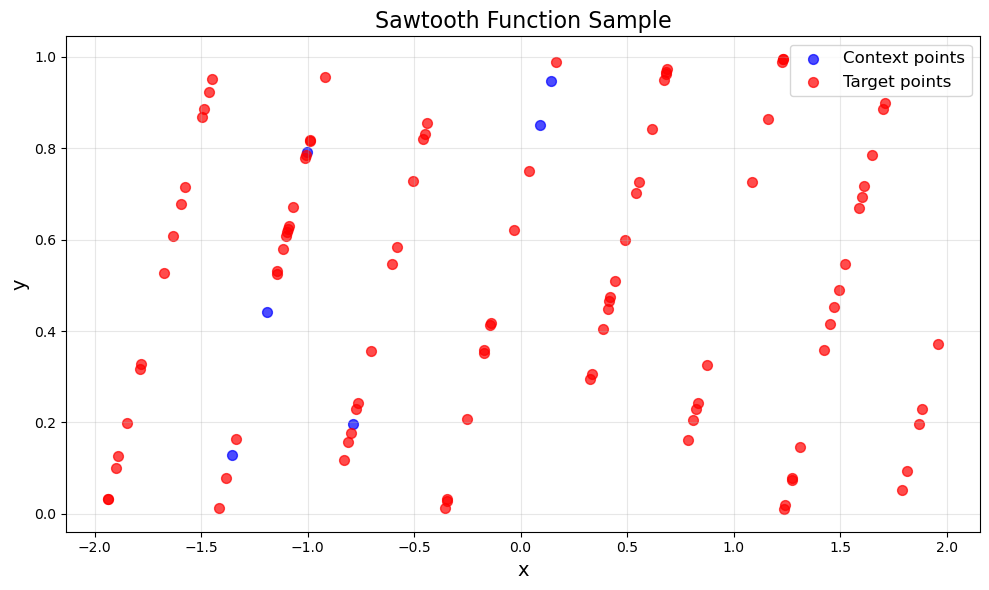

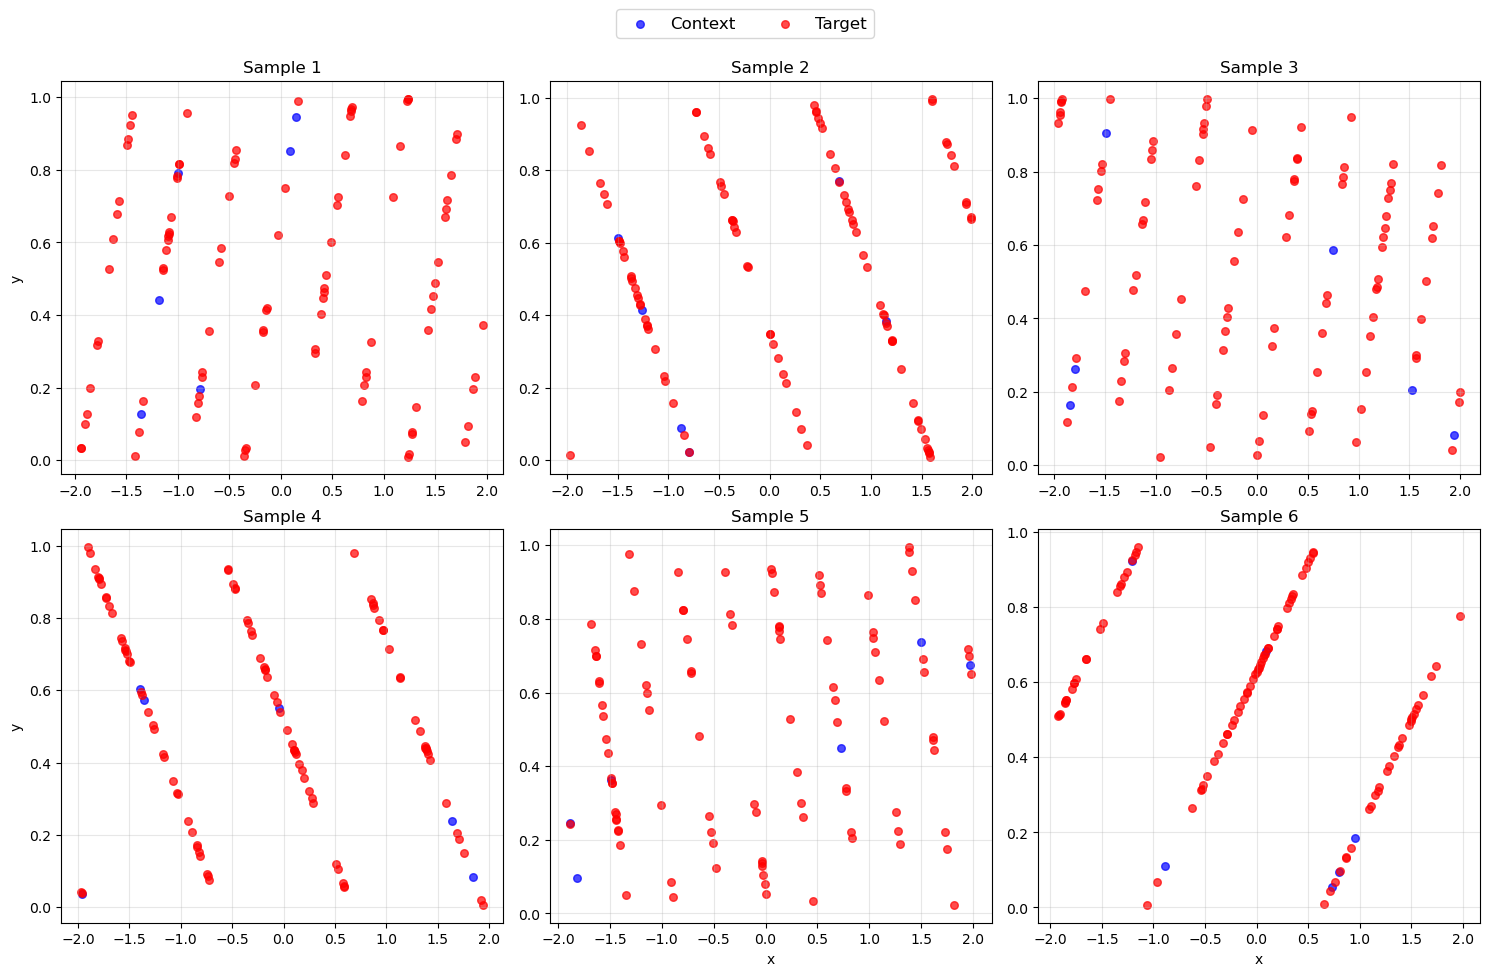

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_batch_sample(batch, sample_idx=0, figsize=(10, 6), ctx_color='blue', tar_color='red'):
    """
    Plot a single sample from a batch with context and target points in different colors.
    
    Args:
        batch: The batch containing xc, yc, xt, yt data
        sample_idx: Index of the sample to plot from the batch
        figsize: Size of the figure
        ctx_color: Color for context points
        tar_color: Color for target points
    """
    plt.figure(figsize=figsize)
    
    # Extract the sample at the specified index
    xc = batch.xc[sample_idx].detach().cpu().numpy()
    yc = batch.yc[sample_idx].detach().cpu().numpy()
    xt = batch.xt[sample_idx].detach().cpu().numpy()
    yt = batch.yt[sample_idx].detach().cpu().numpy()
    
    # Plot context points
    plt.scatter(xc, yc, color=ctx_color, label='Context points', s=50, alpha=0.7)
    
    # Plot target points
    plt.scatter(xt, yt, color=tar_color, label='Target points', s=50, alpha=0.7)
    
    # Add labels and legend
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('Sawtooth Function Sample', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot a sample from the sawtooth batch
plot_batch_sample(sawtooth_batch)

# Plot multiple samples in a grid
def plot_batch_grid(batch, nrows=2, ncols=2, figsize=(15, 10), ctx_color='blue', tar_color='red'):
    """
    Plot multiple samples from a batch in a grid layout.
    
    Args:
        batch: The batch containing xc, yc, xt, yt data
        nrows: Number of rows in the grid
        ncols: Number of columns in the grid
        figsize: Size of the figure
        ctx_color: Color for context points
        tar_color: Color for target points
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < min(nrows * ncols, batch.xc.shape[0]):
            # Extract the sample
            xc = batch.xc[i].detach().cpu().numpy()
            yc = batch.yc[i].detach().cpu().numpy()
            xt = batch.xt[i].detach().cpu().numpy()
            yt = batch.yt[i].detach().cpu().numpy()
            
            # Plot context points
            ax.scatter(xc, yc, color=ctx_color, label='Context' if i == 0 else "", s=30, alpha=0.7)
            
            # Plot target points
            ax.scatter(xt, yt, color=tar_color, label='Target' if i == 0 else "", s=30, alpha=0.7)
            
            # Add grid and title
            ax.grid(True, alpha=0.3)
            ax.set_title(f'Sample {i+1}')
            
            # Only add x and y labels for the bottom and left plots
            if i >= nrows * (ncols - 1):  # Bottom row
                ax.set_xlabel('x')
            if i % ncols == 0:  # Leftmost column
                ax.set_ylabel('y')
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the legend
    plt.show()

# Plot a grid of sawtooth samples
plot_batch_grid(sawtooth_batch, nrows=2, ncols=3)


In [2]:
import torch
from inference.ar_custom import ar_sample, ar_log_likelihood
xc = torch.randn(1,9,1)
yc = torch.randn(1,9,1)
xt = torch.randn(1,2,1)
lbanp_ar_model.eval()
with torch.no_grad():
    lbanp_ar_model.reset_stored_qkv()
    y_sampled, y_noiseless, pred_dists_1 = ar_sample(lbanp_ar_model, xc, yc, xt, seed=1)
    lbanp_ar_model.reset_stored_qkv()
    y_mean, y_std, y_noiseless, pred_dists_2 = lbanp_ar_model.sample_ar(xc, yc, xt, num_samples=1, seed=1)

ar_sample tensor([[[0.7904]]])
last q torch.Size([4, 8, 16]) tensor([[ 0.5329, -0.7130, -1.3765, -0.4572,  0.3054, -0.7326,  0.5567,  0.0737],
        [ 0.2016, -0.6459, -0.2842,  0.2112, -0.4179,  0.2372,  0.4591, -0.2747],
        [-0.3923,  0.2125, -0.1302,  0.5948,  0.8957,  1.4339,  0.1077,  0.8359],
        [ 0.8761,  0.3450,  1.0214, -0.2732,  0.1233, -0.2292,  1.0132, -0.7434]])
now q torch.Size([4, 8, 16]) tensor([[ 0.5329, -0.7130, -1.3765, -0.4572,  0.3054, -0.7326,  0.5567,  0.0737],
        [ 0.2016, -0.6459, -0.2842,  0.2112, -0.4179,  0.2372,  0.4591, -0.2747],
        [-0.3923,  0.2125, -0.1302,  0.5948,  0.8957,  1.4339,  0.1077,  0.8359],
        [ 0.8761,  0.3450,  1.0214, -0.2732,  0.1233, -0.2292,  1.0132, -0.7434]])
prev last_qkv_before_out torch.Size([1, 8, 64]) tensor([[-0.6649, -0.3888, -0.6873, -0.3603, -0.5983, -0.5065, -0.7363, -0.5870]])
now qkv before out torch.Size([1, 8, 64]) tensor([[-0.6649, -0.5618, -0.6873, -0.3603, -0.5983, -0.5065, -0.7363, -0.5870

RuntimeError: The size of tensor a (9) must match the size of tensor b (8) at non-singleton dimension 2

In [ ]:
import timeit

lbanp_model.eval()

print("rollout=False")
execution_time = timeit.timeit(
    lambda: lbanp_model.predict(batch.xc, batch.yc, batch.xt, rollout=False),
    number=1000
)
print(f"Time taken: {execution_time:.4f} seconds")
pred_false = lbanp_model.predict(batch.xc, batch.yc, batch.xt, rollout=False)

print("\nrollout=True")
execution_time = timeit.timeit(
    lambda: lbanp_model.predict(batch.xc, batch.yc, batch.xt, rollout=True),
    number=1000
)
print(f"Time taken: {execution_time:.4f} seconds")
pred_true = lbanp_model.predict(batch.xc, batch.yc, batch.xt, rollout=True)

rollout=False
Time taken: 10.0140 seconds

rollout=True


In [7]:
import torch
lbanp_model.eval()
with torch.no_grad():
    pred = lbanp_ar_model.predict_ar(batch.xc, batch.yc, batch.xt, num_samples=1)

In [8]:
yt_mean, yt_std, yt_noiseless = pred

In [9]:
yt_noiseless.shape

torch.Size([1, 16, 26, 1])

In [2]:
from inference.ar_custom import ar_sample, no_cheat_ar_log_likelihood, ar_log_likelihood
import torch
with torch.no_grad():
    ll = no_cheat_ar_log_likelihood(lbanp_model, batch.xc, batch.yc, batch.xt, batch.yt, num_samples=20, seed=None, smooth=False, covariance_est="scm")
    ar_ll = ar_log_likelihood(lbanp_model, batch.xc, batch.yc, batch.xt, batch.yt, seed=None)


In [7]:
ll

tensor([-0.8452, -0.8902, -1.0395, -1.5630, -0.9309, -2.5211, -0.7606, -1.0213,
        -1.0649, -1.0498, -1.5483, -0.8410, -0.7995, -1.1116, -1.2891, -0.8364])

In [8]:
ar_ll

tensor([-1.0373, -0.9877, -1.0060, -1.1885, -1.0843, -1.7983, -0.9429, -1.0488,
        -0.9631, -1.0664, -1.2680, -1.0956, -0.9494, -0.9987, -1.1018, -1.0033])

In [10]:

from models.lbanp import LBANP
import yaml
import os.path as osp
import torch

name = "lbanp"
device = "cpu"


# lbanp_model = LBANP(num_latents=8,
#                 dim_x= 2,
#                 dim_y= 5,
#                 d_model=16,
#                 emb_depth=3,
#                 dim_feedforward=64,
#                 nhead=1,
#                 dropout=0.0,
#                 num_layers=4,
#                 drop_y=0.5,
#                 device="cpu")

lbanp_model = LBANP(num_latents=8,
                dim_x= 1,
                dim_y= 1,
                d_model=64,
                emb_depth=4,
                dim_feedforward=128,
                nhead=4,
                dropout=0.0,
                num_layers=6)

with open(osp.join("configs", "gp", f"{name}.yaml")) as g:
    config = yaml.safe_load(g)

path = osp.join("results", "gp", "lbanp", "lbanp-num_latents-8")
filename = 'ckpt.tar'

model = LBANP(**config).to(device)
model.device = torch.device(device)
model.eval()
file = osp.join(path, filename)
if not osp.exists(file):
    raise FileNotFoundError(file)
else:
    ckpt = torch.load(file)
    model.load_state_dict(ckpt.model)


from data.gp import GPSampler, RBFKernel, Matern52Kernel
kernel = RBFKernel()
sampler = GPSampler(kernel)
batch, length, scale = sampler.sample(batch_size=1,
            num_ctx=None,
            num_tar=5,
            max_num_points=50,
            xt_range=(2, 6),
            device='cpu',
            return_params=True)

In [11]:
length, scale

(tensor([[[[0.2532]]]]), tensor([[[0.2810]]]))

In [12]:
from inference.ar_custom import ar_sample, no_cheat_ar_log_likelihood, ar_log_likelihood
from models.perfect_gp import PerfectGP
from data.gp import RBFKernelNonRandom
perfect_gp = PerfectGP(kernel=RBFKernelNonRandom(length=length, scale=scale))
import torch
with torch.no_grad():
    # y_sampled, y_noiseless, pred_dists, smoothed_pred_dists = ar_sample(lbanp_model, batch.xc, batch.yc, batch.xt, seed=1)
    ll = no_cheat_ar_log_likelihood(lbanp_model, batch.xc, batch.yc, batch.xt, batch.yt, num_samples=100, seed=None, smooth=False, covariance_est="bayesian", batch_size_targets=1, nu_p=1, l=length, s=scale)
    normal_ll = lbanp_model(batch, use_ar=False).tar_ll
    ar_ll = ar_log_likelihood(lbanp_model, batch.xc, batch.yc, batch.xt, batch.yt, seed=None)
    perfect_ll = perfect_gp(batch).tar_ll

print(ll.mean(), ar_ll.mean(), normal_ll.mean(), perfect_ll.mean())

bayesian_cov tensor([[ 1.5679,  0.0612, -0.0272, -0.0153,  0.0462],
        [ 0.0612,  1.5159,  0.1174,  0.0597,  0.0878],
        [-0.0272,  0.1174,  1.4946, -0.0287,  0.0953],
        [-0.0153,  0.0597, -0.0287,  1.6156, -0.0266],
        [ 0.0462,  0.0878,  0.0953, -0.0266,  1.6165]])
diagonal matrix tensor([[1.5408, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.5744, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.5866, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.5777, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.5572]])
sample covariance matrix tensor([[ 1.5958,  0.1242, -0.0553, -0.0310,  0.0938],
        [ 0.1242,  1.4557,  0.2383,  0.1212,  0.1782],
        [-0.0553,  0.2383,  1.3997, -0.0583,  0.1934],
        [-0.0310,  0.1212, -0.0583,  1.6547, -0.0541],
        [ 0.0938,  0.1782,  0.1934, -0.0541,  1.6776]])
alpha 0.4925373134328358
true covariance tensor([[6.4305e-02, 3.1190e-11, 3.7928e-35, 7.5257e-16, 2.0798e-02],
        [3.1190e-11, 7.8943e-02,

In [13]:
perfect_gp.predict(batch.xc, batch.yc, batch.xt)[0].covariance_matrix


tensor([[7.9343e-02, 3.1191e-11, 3.7928e-35, 7.5257e-16, 2.1243e-02],
        [3.1191e-11, 7.9343e-02, 3.7701e-09, 2.7396e-02, 3.5859e-07],
        [3.7928e-35, 3.7701e-09, 7.9343e-02, 6.1016e-06, 5.3139e-27],
        [7.5257e-16, 2.7396e-02, 6.1016e-06, 7.9343e-02, 9.1387e-11],
        [2.1243e-02, 3.5859e-07, 5.3139e-27, 9.1387e-11, 7.9343e-02]])

In [5]:
ar_ll.mean()

tensor(-1.3693)

In [6]:
normal_ll

tensor(-1.3698)

In [9]:
ar_pred = model.ar_predict(batch.xc, batch.yc, batch.xt)

In [10]:
ar_pred.loc

tensor([[[-4.9805e-01],
         [-2.1439e-01],
         [-7.0436e-02],
         [-3.8150e-01],
         [ 1.3432e-01],
         [-2.1759e-01]],

        [[-1.0552e+00],
         [-1.4019e+00],
         [-1.0560e+00],
         [ 1.5774e+00],
         [-8.5855e-01],
         [ 1.4868e+00]],

        [[-1.0756e-01],
         [ 9.7629e-01],
         [ 1.6945e+00],
         [ 1.6219e+00],
         [-1.5045e-01],
         [-8.5618e-01]],

        [[-1.6472e-01],
         [ 6.9761e-02],
         [ 1.4657e-01],
         [ 2.6029e-01],
         [-2.1780e-01],
         [ 4.2241e-01]],

        [[ 3.1720e-01],
         [-1.3526e-01],
         [ 3.2057e-01],
         [ 3.3987e-01],
         [ 3.2335e-01],
         [-4.9626e-02]],

        [[ 3.5101e-01],
         [-7.4132e-06],
         [ 1.1210e+00],
         [ 5.4672e-01],
         [ 7.0842e-01],
         [ 1.0338e+00]],

        [[-1.7356e-01],
         [ 8.7545e-02],
         [-1.5150e-01],
         [-1.8290e-01],
         [-3.6729e-03],
    

In [11]:
model.latents

Parameter containing:
tensor([[-5.2829e-01, -6.5334e-01,  3.0985e+00, -1.3711e+00, -1.7328e+00,
         -5.9612e-01,  4.6291e-01, -5.1603e-01, -8.6992e-01,  5.4297e-02,
          1.9330e-01, -4.9053e-01,  9.7111e-01,  2.5913e+00,  1.6435e+00,
          6.1639e-01,  1.4586e+00, -2.2873e+00,  8.3987e-01,  3.4112e-01,
         -9.9662e-01, -3.1962e-01, -6.2789e-01, -1.5592e+00, -3.2935e-01,
         -4.9620e-02,  8.0759e-02,  5.3290e-01, -3.0790e-01,  2.7566e-01,
         -2.1659e-01,  4.6147e-01, -5.2832e-01, -8.6208e-01, -1.8639e-01,
          7.3401e-01,  1.8744e+00, -4.3843e-01, -1.3752e+00,  4.8039e-01,
         -3.8753e-01,  5.9233e-01,  2.5546e-01,  3.6070e+00,  1.0225e+00,
          1.4219e+00, -6.2496e-02, -1.3350e+00, -6.3257e-02,  8.0941e-01,
         -6.2201e-01,  2.5051e-01, -5.2361e-01,  2.8048e+00,  1.8173e-01,
         -2.4239e-01, -3.1172e-01,  1.9425e+00,  8.4579e-01, -1.1546e+00,
          7.8763e-01, -3.4105e-01,  1.5788e-01,  2.2112e-01],
        [ 1.0704e-01, -2.853

In [12]:
batch.yc.shape

torch.Size([8, 512, 5])

In [13]:
batch.xt.shape

torch.Size([8, 50, 2])

In [14]:
batch.yt.shape

torch.Size([8, 50, 5])

In [7]:
ll_loss, pred = lbanp_model(batch)

In [14]:
tnp_model(batch)

AttrDict({'loss_target': tensor(666.4536, grad_fn=<NegBackward0>), 'loss_ctx': tensor(1781.4780, grad_fn=<MeanBackward0>), 'loss': tensor(2447.9316, grad_fn=<AddBackward0>), 'mean_std': tensor(0.0412, grad_fn=<MeanBackward0>), 'rmse': tensor(336.7043, grad_fn=<MeanBackward0>)})

In [17]:
pred.sample(torch.Size([10]))[1]

tensor([[[-0.4370, -1.0098,  0.1075, -0.9991,  0.4572],
         [-0.1563, -0.3379,  0.4788,  0.1298,  0.6714],
         [ 0.2853, -0.2805,  0.3360,  0.8649, -0.9022],
         ...,
         [ 1.2777,  0.1652,  0.6480,  0.2400,  1.1537],
         [ 0.7377,  0.2597,  1.0902, -0.0205, -0.4204],
         [ 0.1903, -0.3400,  0.1030, -0.1797,  0.2685]],

        [[-0.3725,  0.3566, -1.8452,  0.7515,  0.4054],
         [ 0.6287, -0.5361,  1.3953,  1.1158, -0.8499],
         [-0.5555, -0.6780,  3.5492,  0.5310,  1.0871],
         ...,
         [ 1.2121,  0.1738,  2.3070, -1.4268,  1.1481],
         [ 1.1972, -0.1266,  0.5311, -0.2256,  0.8538],
         [ 1.8189, -0.7754, -0.6902, -0.3359, -0.3103]],

        [[ 0.8968,  0.4521,  0.4219, -1.3565, -0.3342],
         [-1.7084,  0.4685,  1.7808,  0.9149,  0.6502],
         [ 1.3056, -1.0105, -0.4376,  0.3604,  2.1575],
         ...,
         [ 0.1437, -1.3362, -0.9561,  0.4158,  0.5472],
         [ 1.8388, -0.7121, -1.5469, -0.1130, -0.5621],
  

In [23]:
batch.yc.shape

torch.Size([8, 512, 5])

In [8]:
import numpy as np
a = np.random.randn(3,2,2)

In [9]:
a

array([[[ 0.21669559, -0.74235375],
        [-0.16376122, -0.70650212]],

       [[-0.53418005,  0.00455652],
        [ 0.57478282,  0.07178991]],

       [[ 0.75321925,  0.30662907],
        [ 0.62068709,  0.79254104]]])

In [10]:
a.reshape(-1,2).reshape(3,2,2)

array([[[ 0.21669559, -0.74235375],
        [-0.16376122, -0.70650212]],

       [[-0.53418005,  0.00455652],
        [ 0.57478282,  0.07178991]],

       [[ 0.75321925,  0.30662907],
        [ 0.62068709,  0.79254104]]])